# Temperature lapsing and data_step
The size discrepancy between MERIT basins and the typical coverage of ERA5 grid cells makes it appropriate to apply a temperature lapse rate. This script loops over existing basin-averaged forcing files and applies a lapse rate to the `airtemp` variable. Lapse arte is determined based on the average elevation difference between the basin shape and the ERA5 grid cell(s) that cover the basin.

In addition, this script adds the `data_step` variable to each forcing file, which SUMMA needs to know the time resolution of the forcing inputs.

#### Environmental Lapse Rate
The temperature lapse rate is assumed to have a constant value of `0.0065` `[K m-1]` (Wallace & Hobbs, 2006, p. 421).

_Wallace, J., and P. Hobbs (2006), Atmospheric Science: An Introductory Survey, 483 pp., Academic Press, Burlington, Mass_

In [1]:
# modules
import os
import numpy as np
import xarray as xr
import pandas as pd
from pathlib import Path
from shutil import copyfile
from datetime import datetime

#### Control file handling

In [2]:
# Easy access to control file folder
controlFolder = Path('../../0_control_files')

In [3]:
# Store the name of the 'active' file in a variable
controlFile = 'control_active.txt'

In [4]:
# Function to extract a given setting from the control file
def read_from_control( file, setting ):
    
    # Open 'control_active.txt' and ...
    with open(file) as contents:
        for line in contents:
            
            # ... find the line with the requested setting
            if setting in line and not line.startswith('#'):
                break
    
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
       
    # Return this value    
    return substring

In [5]:
# Function to specify a default path
def make_default_path(suffix):
    
    # Get the root path
    rootPath = Path( read_from_control(controlFolder/controlFile,'root_path') )
    
    # Get the domain folder
    domainName = read_from_control(controlFolder/controlFile,'domain_name')
    domainFolder = 'domain_' + domainName
    
    # Specify the forcing path
    defaultPath = rootPath / domainFolder / suffix
    
    return defaultPath

#### Find location of intersection file

In [6]:
# Intersected shapefile path. Name is set by EASYMORE as [prefix]_intersected_shapefile.shp
intersect_path = read_from_control(controlFolder/controlFile,'intersect_forcing_path')

In [7]:
# Specify default path if needed
if intersect_path == 'default':
    intersect_path = make_default_path('shapefiles/catchment_intersection/with_forcing') # outputs a Path()
else:
    intersect_path = Path(intersect_path) # make sure a user-specified path is a Path()

In [8]:
# Make the file name
domain = read_from_control(controlFolder/controlFile,'domain_name')
intersect_name = domain + '_intersected_shapefile.csv' # can also be .shp, but using the .csv is easier on memory

#### Find where the EASYMORE-prepared forcing files are

In [9]:
# Forcing files as produced by EASYMORE
forcing_easymore_path = read_from_control(controlFolder/controlFile,'forcing_basin_avg_path')

In [10]:
# Specify default path if needed
if forcing_easymore_path == 'default':
    forcing_easymore_path = make_default_path('forcing/3_basin_averaged_data') # outputs a Path()
else:
    forcing_easymore_path = Path(forcing_easymore_path) # make sure a user-specified path is a Path()

In [11]:
# Find the files
_,_,forcing_files = next(os.walk(forcing_easymore_path))

#### Find the time step size of the forcing data

In [12]:
# Value in control file
data_step = read_from_control(controlFolder/controlFile,'forcing_time_step_size')

In [13]:
# Convert to int
data_step = int(data_step)

#### Find where the final forcing needs to go

In [14]:
# Location for SUMMA-ready files
forcing_summa_path = read_from_control(controlFolder/controlFile,'forcing_summa_path')

In [15]:
# Specify default path if needed
if forcing_summa_path == 'default':
    forcing_summa_path = make_default_path('forcing/4_SUMMA_input') # outputs a Path()
else:
    forcing_summa_path = Path(forcing_summa_path) # make sure a user-specified path is a Path()

In [16]:
# Make the folder if it doesn't exist
forcing_summa_path.mkdir(parents=True, exist_ok=True)

#### Find the area-weighted lapse value for each basin

In [17]:
# Load the intersection file
topo_data = pd.read_csv(intersect_path/intersect_name) 

In [18]:
# Find hruId name in user's shapefile
hru_ID_name = read_from_control(controlFolder/controlFile,'catchment_shp_hruid')
gru_ID_name = read_from_control(controlFolder/controlFile,'catchment_shp_gruid')

In [19]:
# Specify the column names
# Note that column names are truncated at 10 characters in the ESRI shapefile, but NOT in the .csv we use here
gru_ID         = 'S_1_' + gru_ID_name # EASYMORE prefix + user's hruId name
hru_ID         = 'S_1_' + hru_ID_name # EASYMORE prefix + user's hruId name
forcing_ID     = 'S_2_ID'             # fixed name assigned by EASYMORE
catchment_elev = 'S_1_elev_mean'      # EASYMORE prefix + name used in catchment+DEM intersection step
forcing_elev   = 'S_2_elev_m'         # EASYMORE prefix + name used in ERA5 shapefile generation
weights        = 'weight'             # EASYMORE feature

In [20]:
# Define the lapse rate
lapse_rate = 0.0065 # [K m-1]

In [21]:
# Calculate weighted lapse values for each HRU 
# Note that these lapse values need to be ADDED to ERA5 temperature data
topo_data['lapse_values'] = topo_data[weights] * lapse_rate * \
    (topo_data[forcing_elev] - topo_data[catchment_elev]) # [K]

In [22]:
# Find the total lapse value per basin; i.e. sum the individual contributions of each HRU+ERA5-grid overlapping part
lapse_values = topo_data.groupby([gru_ID,hru_ID]).lapse_values.sum().reset_index()

In [23]:
# Sort and set hruID as the index variable
lapse_values = lapse_values.sort_values(hru_ID).set_index(hru_ID)
lapse_values

,S_1_GRU_ID,lapse_values
S_1_HRU_ID,,
1,71028597,-0.530803
2,71028609,-0.413910
3,71028676,-0.863720
4,71028700,-0.666452
5,71028740,-1.204602
...,...,...
114,71030774,4.228418
115,71031120,4.034569
116,71031359,3.808350


In [24]:
lapse_values['lapse_values'].values

array([-0.53080339, -0.4139101 , -0.86372035, -0.66645241, -1.20460167,
       -1.5746951 , -1.32778159, -0.6674116 , -0.04476636,  0.98314857,
       -0.31718611, -1.05653687, -0.15626734, -1.50455369, -1.5866296 ,
       -0.34931969, -1.88584627, -1.1627504 , -0.78166432, -0.32949239,
       -1.10062264, -2.07139943, -2.15017622, -1.96050107, -1.65279644,
       -1.44900648, -1.76136919, -2.06491089, -1.2496712 , -1.58894415,
       -1.50327352, -0.98183415, -2.69426726, -2.29230857, -1.32682617,
       -1.81413165, -0.63797317, -1.89566932, -0.91513997, -1.06523235,
       -0.68307467, -2.40340754, -0.9828666 , -2.03269987, -1.00217416,
       -0.80221279, -1.01821046, -0.60629124,  2.20874312,  2.55817335,
        2.75609708,  3.27298514,  2.39364004,  2.62071082,  2.87247782,
        3.5091499 ,  3.5641254 ,  3.94130768,  4.15876513,  3.21665357,
        2.70481439,  3.31225587,  1.90095689,  2.07705035,  3.00127523,
        1.67074649,  2.91552636,  2.38271938,  2.84854313,  1.73

In [25]:
# Close the main file
del topo_data # hopefully this saves some RAM but this is apparently not so straightforward in Python.. Can't hurt

#### Check what we're doing

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [27]:
# Find location of DEM intersection for shapes and elevation
elev_catchment_path = read_from_control(controlFolder/controlFile,'intersect_dem_path')
elev_catchment_name = read_from_control(controlFolder/controlFile,'intersect_dem_name')

# Specify default path if needed
if elev_catchment_path == 'default':
    elev_catchment_path = make_default_path('shapefiles/catchment_intersection/with_dem') # outputs a Path()
else:
    elev_catchment_path = Path(elev_catchment_path) # make sure a user-specified path is a Path()

In [28]:
# Find the GRU and HRU identifiers
hm_gruid = read_from_control(controlFolder/controlFile,'catchment_shp_gruid')
hm_hruid = read_from_control(controlFolder/controlFile,'catchment_shp_hruid')

In [29]:
# catchment with DEM
catchment = gpd.read_file(elev_catchment_path/elev_catchment_name)

In [30]:
# Create a shapefile with only GRU boundaries for overlay
hm_grus_only = catchment[[hm_gruid,'geometry']] # keep only the gruId and geometry
hm_grus_only = hm_grus_only.dissolve(by=hm_gruid) # Dissolve HRU delineation

In [31]:
# ensure that HRU_ID is the index
catchment = catchment.set_index(hm_hruid)

In [32]:
# merge with the lapse rate dataframe
catchment['lapse_rate'] = lapse_values['lapse_values']

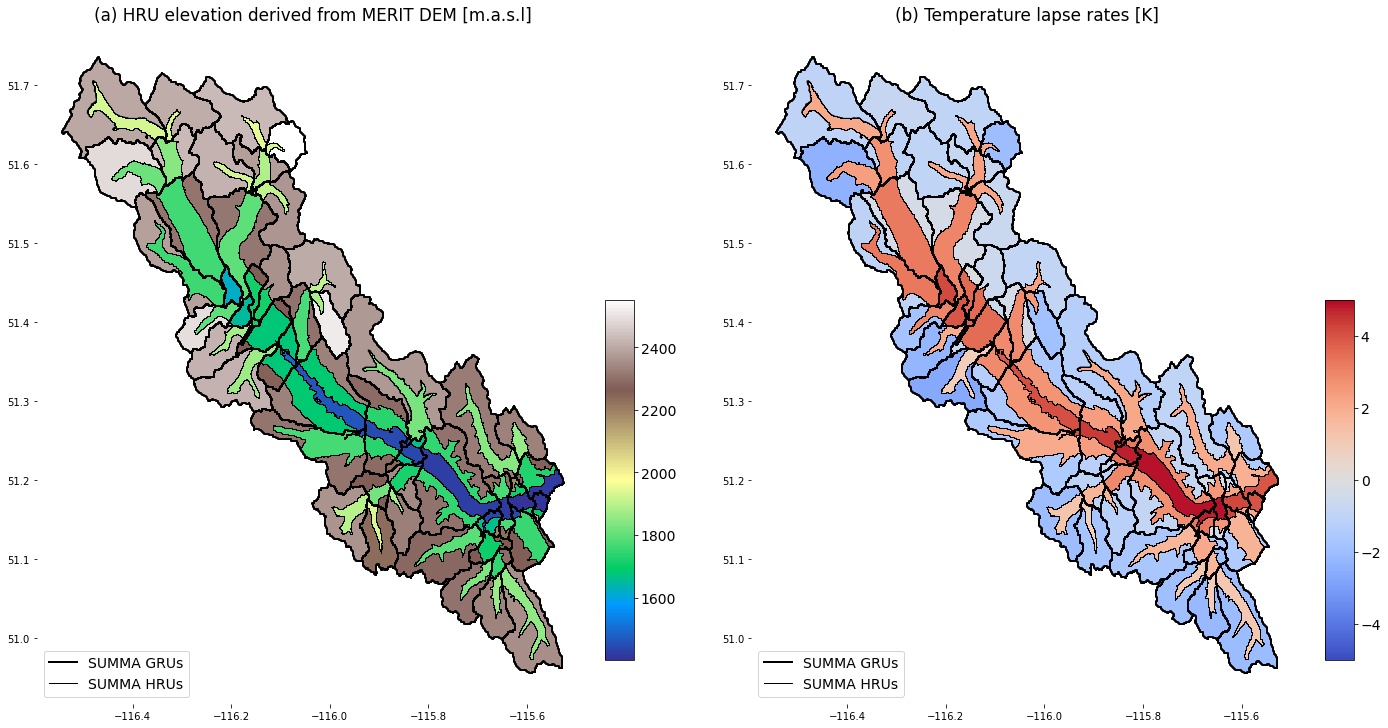

In [33]:
# plot
cmap_elev = 'terrain'
cmap_lapse = 'coolwarm'

# figure
fig, axs = plt.subplots(1,2,figsize=(20,10))
plt.tight_layout()
plt.rcParams.update({'font.size': 14})

# --- elevation
axId = 0

# Data
catchment.plot(ax=axs[axId], column='elev_mean',edgecolor='k', cmap = cmap_elev, legend=False)
hm_grus_only.plot(ax=axs[axId],facecolor='none',edgecolor='k',linewidth=2) 

# Custom colorbar
cax = fig.add_axes([0.46, 0.1, 0.02, 0.5])
vmin,vmax = catchment['elev_mean'].min(),catchment['elev_mean'].max()
sm = plt.cm.ScalarMappable(cmap=cmap_elev, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)


# Custom legend
lines = [Line2D([0], [0], color='k', lw=2),
         Line2D([0], [0], color='k', lw=1)]
label = ['SUMMA GRUs',
         'SUMMA HRUs']
axs[axId].legend(lines,label,loc='lower left');

# Chart junk
axs[axId].set_title('(a) HRU elevation derived from MERIT DEM [m.a.s.l]');
axs[axId].set_frame_on(False)


# --- lapse rates
axId = 1

# Data
catchment.plot(ax=axs[axId], column='lapse_rate',edgecolor='k', cmap = cmap_lapse, legend=False, vmin=-5, vmax=5)
hm_grus_only.plot(ax=axs[axId],facecolor='none',edgecolor='k',linewidth=2) 

# Custom colorbar
cax = fig.add_axes([0.96, 0.1, 0.02, 0.5])
vmin,vmax = catchment['lapse_rate'].min(),catchment['lapse_rate'].max()
sm = plt.cm.ScalarMappable(cmap=cmap_lapse, norm=plt.Normalize(vmin=-5, vmax=5))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)


# Custom legend
lines = [Line2D([0], [0], color='k', lw=2),
         Line2D([0], [0], color='k', lw=1)]
label = ['SUMMA GRUs',
         'SUMMA HRUs']
axs[axId].legend(lines,label,loc='lower left');

# Chart junk
axs[axId].set_title('(b) Temperature lapse rates [K]');
axs[axId].set_frame_on(False)

#### Loop over forcing files; apply lapse rates and add data_step variable

In [49]:
# Initiate the loop
for file in forcing_files:
    
    # Progress
    print('Starting on ' + file)
    
    # load the data
    with xr.open_dataset(forcing_easymore_path / file) as dat:
    
        # --- Temperature lapse rates
        # Find the lapse rates by matching the HRU order in the forcing file with that in 'lapse_values'
        lapse_values_sorted = lapse_values['lapse_values'].loc[dat['hruId'].values]
    
        # Make a data array of size (nTime,nHru) 
        addThis = xr.DataArray(np.tile(lapse_values_sorted.values, (len(dat['time']),1)), dims=('time','hru')) 
        
        # Get the air temperature variables
        tmp_longname = dat['airtemp'].long_name
        tmp_units = dat['airtemp'].units
    
        # Subtract lapse values from existing temperature data - this creates a new variable without meta-data
        dat['airtemp'] = dat['airtemp'] + addThis
        
        # Add the attributes back in
        dat.airtemp.attrs['long_name'] = tmp_longname
        dat.airtemp.attrs['units'] = tmp_units
    
        # --- Time step specification 
        dat['data_step'] = data_step
        dat.data_step.attrs['long_name'] = 'data step length in seconds'
        dat.data_step.attrs['units'] = 's'
    
        # --- Save to file in new location
        dat.to_netcdf(forcing_summa_path/file) 

Starting on BowAtBanff_remapped_2008-01-01-00-00-00-GT.nc
Starting on BowAtBanff_remapped_2008-01-01-00-00-00.nc
Starting on BowAtBanff_remapped_2008-02-01-00-00-00.nc
Starting on BowAtBanff_remapped_2008-03-01-00-00-00.nc
Starting on BowAtBanff_remapped_2008-04-01-00-00-00.nc
Starting on BowAtBanff_remapped_2008-05-01-00-00-00.nc
Starting on BowAtBanff_remapped_2008-06-01-00-00-00.nc
Starting on BowAtBanff_remapped_2008-07-01-00-00-00.nc
Starting on BowAtBanff_remapped_2008-08-01-00-00-00.nc
Starting on BowAtBanff_remapped_2008-09-01-00-00-00.nc
Starting on BowAtBanff_remapped_2008-10-01-00-00-00.nc
Starting on BowAtBanff_remapped_2008-11-01-00-00-00.nc
Starting on BowAtBanff_remapped_2008-12-01-00-00-00.nc
Starting on BowAtBanff_remapped_2009-01-01-00-00-00.nc
Starting on BowAtBanff_remapped_2009-02-01-00-00-00.nc
Starting on BowAtBanff_remapped_2009-03-01-00-00-00.nc
Starting on BowAtBanff_remapped_2009-04-01-00-00-00.nc
Starting on BowAtBanff_remapped_2009-05-01-00-00-00.nc
Startin

In [50]:
dat = xr.open_dataset(forcing_summa_path/file)

In [51]:
dat

<xarray.Dataset>
Dimensions:    (hru: 118, time: 744)
Coordinates:
  * time       (time) datetime64[ns] 2013-12-01 ... 2013-12-31T23:00:00
Dimensions without coordinates: hru
Data variables:
    latitude   (hru) float64 ...
    longitude  (hru) float64 ...
    hruId      (hru) float64 ...
    airpres    (time, hru) float32 ...
    LWRadAtm   (time, hru) float32 ...
    SWRadAtm   (time, hru) float32 ...
    pptrate    (time, hru) float32 ...
    airtemp    (time, hru) float64 ...
    spechum    (time, hru) float32 ...
    windspd    (time, hru) float32 ...
    data_step  int32 ...
Attributes:
    Conventions:  CF-1.6
    Author:       The data were written by SUMMA public workflow scripts
    License:      Copernicus data use license: https://cds.climate.copernicus...
    History:      Created Thu May  6 13:27:59 2021
    Source:       Case: BowAtBanff; remapped by script from library of Sherva...

In [52]:
dat.close()

#### Check what we're doing

In [34]:
# open old and new file
forcing_old = xr.open_dataset(forcing_easymore_path / file)
forcing_new = xr.open_dataset(forcing_summa_path / file)

In [35]:
# Prepare dataframes with temperature for a given time
time = 0
old_temp = {'airtemp': forcing_old['airtemp'].isel(time=time).values, 'hruId': forcing_old['hruId']}
new_temp = {'airtemp': forcing_new['airtemp'].isel(time=time).values, 'hruId': forcing_old['hruId']}

In [36]:
# Make dataframes
df_old_temp = pd.DataFrame(old_temp)
df_new_temp = pd.DataFrame(new_temp)

In [37]:
# Set indices
df_old_temp = df_old_temp.set_index('hruId')
df_new_temp = df_new_temp.set_index('hruId')

In [38]:
# Merge with catchment shapefile
catchment['old_T'] = df_old_temp['airtemp']
catchment['new_T'] = df_new_temp['airtemp']

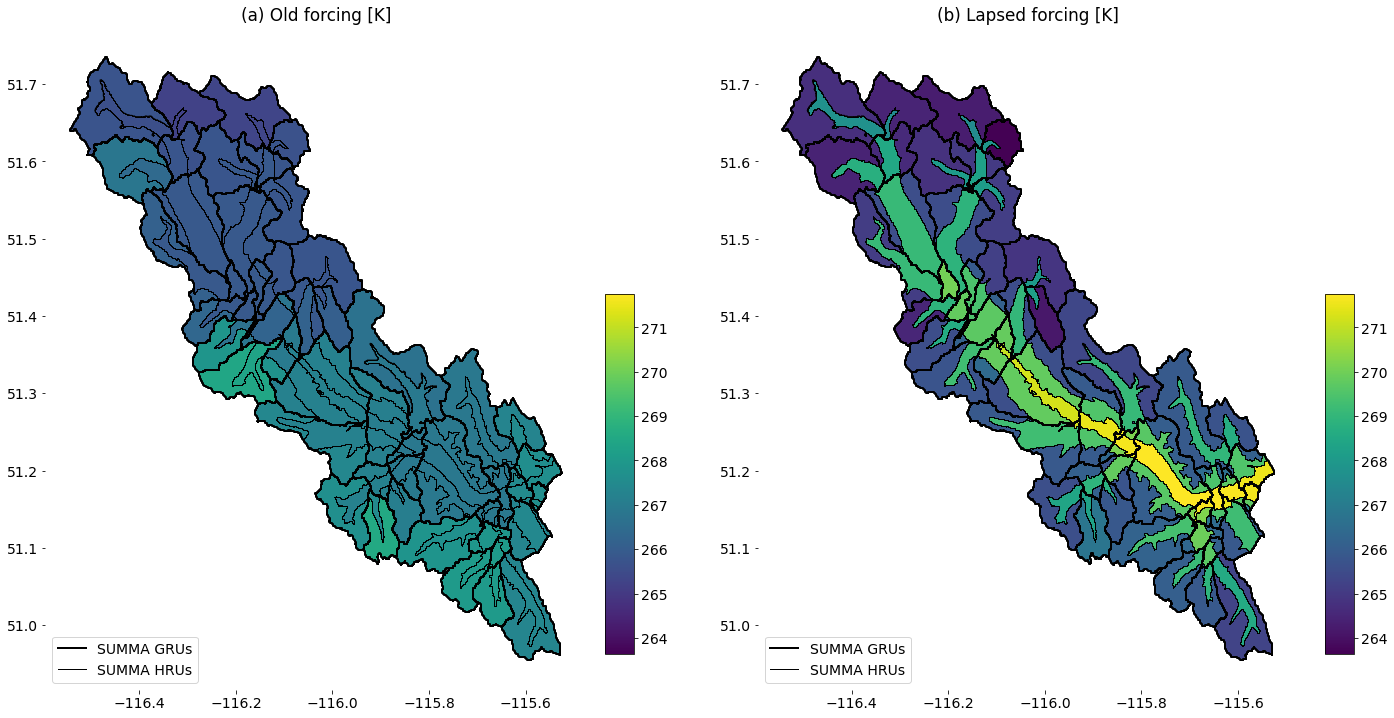

In [39]:
# figure
fig, axs = plt.subplots(1,2,figsize=(20,10))
plt.tight_layout()
plt.rcParams.update({'font.size': 14})

vmin = min(df_new_temp.min().values,df_old_temp.min().values)
vmax = max(df_new_temp.max().values,df_old_temp.max().values)

# --- elevation
axId = 0

# Data
catchment.plot(ax=axs[axId], column='old_T',edgecolor='k', legend=False, vmin=vmin, vmax=vmax)
hm_grus_only.plot(ax=axs[axId],facecolor='none',edgecolor='k',linewidth=2) 

# Custom colorbar
cax = fig.add_axes([0.46, 0.1, 0.02, 0.5])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)


# Custom legend
lines = [Line2D([0], [0], color='k', lw=2),
         Line2D([0], [0], color='k', lw=1)]
label = ['SUMMA GRUs',
         'SUMMA HRUs']
axs[axId].legend(lines,label,loc='lower left');

# Chart junk
axs[axId].set_title('(a) Old forcing [K]');
axs[axId].set_frame_on(False)


# --- lapse rates
axId = 1

# Data
catchment.plot(ax=axs[axId], column='new_T',edgecolor='k', legend=False, vmin=vmin, vmax=vmax)
hm_grus_only.plot(ax=axs[axId],facecolor='none',edgecolor='k',linewidth=2) 

# Custom colorbar
cax = fig.add_axes([0.96, 0.1, 0.02, 0.5])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)


# Custom legend
lines = [Line2D([0], [0], color='k', lw=2),
         Line2D([0], [0], color='k', lw=1)]
label = ['SUMMA GRUs',
         'SUMMA HRUs']
axs[axId].legend(lines,label,loc='lower left');

# Chart junk
axs[axId].set_title('(b) Lapsed forcing [K]');
axs[axId].set_frame_on(False)

In [40]:
# close files
forcing_old.close()
forcing_new.close()

#### Code provenance
Generates a basic log file in the domain folder and copies the control file and itself there.

In [41]:
# Set the log path and file name
logPath = forcing_summa_path
log_suffix = '_temperature_lapse_and_datastep.txt'

In [42]:
# Create a log folder
logFolder = '_workflow_log'
Path( logPath / logFolder ).mkdir(parents=True, exist_ok=True)

In [43]:
# Copy this script
thisFile = '3_temperature_lapsing_and_datastep.ipynb'
copyfile(thisFile, logPath / logFolder / thisFile);

In [44]:
# Get current date and time
now = datetime.now()

In [45]:
# Create a log file 
logFile = now.strftime('%Y%m%d') + log_suffix
with open( logPath / logFolder / logFile, 'w') as file:
    
    lines = ['Log generated by ' + thisFile + ' on ' + now.strftime('%Y/%m/%d %H:%M:%S') + '\n',
             'Applied temperature lapse rate to forcing data and added data_step variable.']
    for txt in lines:
        file.write(txt) 